By: Gani Perez

github: @GaniPerez

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# COVID-19 Time-Series Case/Death Prediction

In this dataset, I would like to model the evolution of COVID-19 cases and deaths in the DMV area. I have a number of datasets from the CDC regarding cases, deaths, and vaccination rates per county, and I will do some small exploratory analyses to look at some potential relationships in order to decide on which features to add into the model. Additionally, I have a bunch of per-county metadata that I pulled from the latest (2019) census report. Unfortunately, a key piece of the puzzle (at least, in terms of predicting deaths) is the hospital utilization, but I haven't been able to find any per-county dataset with this information without scraping the Maryland COVID-19 Dashboard. I don't know how to do that.

My features:
- Longitudinal Features:
    - Cases
    - Deaths
    - Vaccination Rates

There is a lot of data cleaning that needs to be done, so for now I focused on cleaning and analyzing only the longitudinal features. There is some cleaning of the other metadata at the bottom of this notebook, but it has not yet been completed.

### Cleaning up Time Series Data

First, I will start by defining a few functions to help me clean. Later, I will probably package these functions into a class for easy automation.

In [8]:
def process_US_info(df):
    df_t = df.transpose()
    df_t.columns = df_t.loc["Province_State"]
    df_t.rename(columns={"Admin2": "County"}, inplace=True)
    df_t.drop("Province_State", inplace=True)
    df_t.reset_index(inplace=True)
    return df_t

def clean_state_name(name):
    name = name.split('.')[0]
    return name

def melt_df(df, label):
    df2 = pd.melt(df, id_vars=["index", "County"], value_vars=df.columns[1:])
    df2.columns = ["state", "county", "date", label]
    df2 = df2.astype({label:'float'})
    df2 = df2.astype({label:'int'})
    df2['state'] = np.vectorize(clean_state_name)(df2['state'])
    return df2

def select_states(df, states):
    states_string = "|".join(states)
    df2 = df[df['state'].str.match(states_string)]
    return df2
    

#### Starting with deaths by county...

In [9]:
deaths = pd.read_csv("US_deaths.csv", low_memory=False)
deaths

,Province_State,Alabama,Alabama.1,Alabama.2,Alabama.3,Alabama.4,Alabama.5,Alabama.6,Alabama.7,Alabama.8,...,Wyoming.15,Wyoming.16,Wyoming.17,Wyoming.18,Wyoming.19,Wyoming.20,Wyoming.21,Wyoming.22,Wyoming.23,Wyoming.24
0,Admin2,Autauga,Baldwin,Barbour,Bibb,Blount,Bullock,Butler,Calhoun,Chambers,...,Park,Platte,Sheridan,Sublette,Sweetwater,Teton,Uinta,Unassigned,Washakie,Weston
1,1/23/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1/24/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1/25/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1/26/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771,3/3/22,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
772,3/4/22,0.0,5.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
773,3/5/22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
774,3/6/22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
deaths_t = process_US_info(deaths)
deaths_long = melt_df(deaths_t, "deaths")
deaths_long

,state,county,date,deaths
0,Alabama,Autauga,1/23/20,0
1,Alabama,Baldwin,1/23/20,0
2,Alabama,Barbour,1/23/20,0
3,Alabama,Bibb,1/23/20,0
4,Alabama,Blount,1/23/20,0
...,...,...,...,...
2590045,Wyoming,Teton,3/7/22,0
2590046,Wyoming,Uinta,3/7/22,0
2590047,Wyoming,Unassigned,3/7/22,0
2590048,Wyoming,Washakie,3/7/22,0


For now, I am only interested in longitudinal data from the DMV area.

In [10]:
# keep all states; do not select any particular states.
deaths_long_selected = deaths_long

In [11]:
deaths_long_selected['date'] = pd.to_datetime(deaths_long_selected['date'])
deaths_long_selected

,state,county,date,deaths
0,Alabama,Autauga,2020-01-23,0
1,Alabama,Baldwin,2020-01-23,0
2,Alabama,Barbour,2020-01-23,0
3,Alabama,Bibb,2020-01-23,0
4,Alabama,Blount,2020-01-23,0
...,...,...,...,...
2590045,Wyoming,Teton,2022-03-07,0
2590046,Wyoming,Uinta,2022-03-07,0
2590047,Wyoming,Unassigned,2022-03-07,0
2590048,Wyoming,Washakie,2022-03-07,0


In [14]:
deaths_long_selected.groupby(["state", 'date']).agg(sum).reset_index()

,state,date,deaths
0,Alabama,2020-01-23,0
1,Alabama,2020-01-24,0
2,Alabama,2020-01-25,0
3,Alabama,2020-01-26,0
4,Alabama,2020-01-27,0
...,...,...,...
44945,Wyoming,2022-03-03,0
44946,Wyoming,2022-03-04,0
44947,Wyoming,2022-03-05,0
44948,Wyoming,2022-03-06,0


In [20]:
def summarize_by_state(df, col_name):
    return df.groupby(["state", 'date']).agg(sum).reset_index()

In [21]:
deaths_long_selected = summarize_by_state(deaths_long_selected, 'deaths')
deaths_long_selected.head()

,state,date,deaths
0,Alabama,2020-01-23,0
1,Alabama,2020-01-24,0
2,Alabama,2020-01-25,0
3,Alabama,2020-01-26,0
4,Alabama,2020-01-27,0


#### Next, positive case rates by county...

In [22]:
cases = pd.read_csv("US_confirmed_cases.csv", low_memory=False)
cases

,Province_State,Alabama,Alabama.1,Alabama.2,Alabama.3,Alabama.4,Alabama.5,Alabama.6,Alabama.7,Alabama.8,...,Wyoming.15,Wyoming.16,Wyoming.17,Wyoming.18,Wyoming.19,Wyoming.20,Wyoming.21,Wyoming.22,Wyoming.23,Wyoming.24
0,Admin2,Autauga,Baldwin,Barbour,Bibb,Blount,Bullock,Butler,Calhoun,Chambers,...,Park,Platte,Sheridan,Sublette,Sweetwater,Teton,Uinta,Unassigned,Washakie,Weston
1,1/23/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1/24/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1/25/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1/26/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771,3/3/22,-2.0,21.0,1.0,3.0,13.0,0.0,0.0,69.0,1.0,...,3.0,0.0,3.0,1.0,3.0,11.0,-3.0,0.0,0.0,0.0
772,3/4/22,4.0,18.0,0.0,3.0,4.0,1.0,0.0,16.0,2.0,...,3.0,2.0,2.0,1.0,2.0,14.0,3.0,0.0,1.0,0.0
773,3/5/22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
774,3/6/22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
cases_t = process_US_info(cases)
cases_long = melt_df(cases_t, "cases")
cases_long

,state,county,date,cases
0,Alabama,Autauga,1/23/20,0
1,Alabama,Baldwin,1/23/20,0
2,Alabama,Barbour,1/23/20,0
3,Alabama,Bibb,1/23/20,0
4,Alabama,Blount,1/23/20,0
...,...,...,...,...
2590045,Wyoming,Teton,3/7/22,3
2590046,Wyoming,Uinta,3/7/22,-2
2590047,Wyoming,Unassigned,3/7/22,0
2590048,Wyoming,Washakie,3/7/22,-1


In [24]:
cases_long_selected = cases_long

In [25]:
cases_long_selected['date'] = pd.to_datetime(cases_long_selected['date'])
cases_long_selected

,state,county,date,cases
0,Alabama,Autauga,2020-01-23,0
1,Alabama,Baldwin,2020-01-23,0
2,Alabama,Barbour,2020-01-23,0
3,Alabama,Bibb,2020-01-23,0
4,Alabama,Blount,2020-01-23,0
...,...,...,...,...
2590045,Wyoming,Teton,2022-03-07,3
2590046,Wyoming,Uinta,2022-03-07,-2
2590047,Wyoming,Unassigned,2022-03-07,0
2590048,Wyoming,Washakie,2022-03-07,-1


In [26]:
cases_long_selected = summarize_by_state(cases_long_selected, 'cases')
cases_long_selected

,state,date,cases
0,Alabama,2020-01-23,0
1,Alabama,2020-01-24,0
2,Alabama,2020-01-25,0
3,Alabama,2020-01-26,0
4,Alabama,2020-01-27,0
...,...,...,...
44945,Wyoming,2022-03-03,72
44946,Wyoming,2022-03-04,77
44947,Wyoming,2022-03-05,0
44948,Wyoming,2022-03-06,0


In [27]:
### removes entries with null counties.
# cases_long = cases_long[~cases_long['county'].isnull()]
# cases_long

#### Vaccination Status

Unfortunately, per-county vaccination status came from a different data vendor so the structure is slightly different. I will do this cleaning manually.

In [38]:
vaccination = pd.read_csv("US_state_vaccinations.csv", low_memory=False)
vaccination.head()

,date,location,total_vaccinations,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used,total_boosters,total_boosters_per_hundred
0,2021-01-12,Alabama,78134.0,377025.0,70861.0,0.15,1.59,7270.0,1.45,7.69,NaN,NaN,NaN,0.207,NaN,NaN
1,2021-01-13,Alabama,84040.0,378975.0,74792.0,0.19,1.71,9245.0,1.53,7.73,5906.0,5906.0,1205.0,0.222,NaN,NaN
2,2021-01-14,Alabama,92300.0,435350.0,80480.0,NaN,1.88,NaN,1.64,8.88,8260.0,7083.0,1445.0,0.212,NaN,NaN
3,2021-01-15,Alabama,100567.0,444650.0,86956.0,0.28,2.05,13488.0,1.77,9.07,8267.0,7478.0,1525.0,0.226,NaN,NaN
4,2021-01-16,Alabama,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7498.0,1529.0,NaN,NaN,NaN


In [45]:
vaccination_subset = vaccination[["date", "location", "total_distributed", "distributed_per_hundred",
                           "people_fully_vaccinated_per_hundred", "total_vaccinations_per_hundred", 
                           "daily_vaccinations_per_million", 'total_boosters_per_hundred']]
vaccination_subset.columns = ["date", "state", "total_distributed", "distributed_per_hundred",
                           "people_fully_vaccinated_per_hundred", "total_vaccinations_per_hundred", 
                           "daily_vaccinations_per_million", 'total_boosters_per_hundred']
vaccination_subset.head()

,date,state,total_distributed,distributed_per_hundred,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,daily_vaccinations_per_million,total_boosters_per_hundred
0,2021-01-12,Alabama,377025.0,7.69,0.15,1.59,NaN,NaN
1,2021-01-13,Alabama,378975.0,7.73,0.19,1.71,1205.0,NaN
2,2021-01-14,Alabama,435350.0,8.88,NaN,1.88,1445.0,NaN
3,2021-01-15,Alabama,444650.0,9.07,0.28,2.05,1525.0,NaN
4,2021-01-16,Alabama,NaN,NaN,NaN,NaN,1529.0,NaN


In [46]:
vaccination_subset['date'] = pd.to_datetime(vaccination_subset["date"])
vaccination_subset

/tmp/ipykernel_319/451792312.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vaccination_subset['date'] = pd.to_datetime(vaccination_subset["date"])


,date,state,total_distributed,distributed_per_hundred,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,daily_vaccinations_per_million,total_boosters_per_hundred
0,2021-01-12,Alabama,377025.0,7.69,0.15,1.59,NaN,NaN
1,2021-01-13,Alabama,378975.0,7.73,0.19,1.71,1205.0,NaN
2,2021-01-14,Alabama,435350.0,8.88,NaN,1.88,1445.0,NaN
3,2021-01-15,Alabama,444650.0,9.07,0.28,2.05,1525.0,NaN
4,2021-01-16,Alabama,NaN,NaN,NaN,NaN,1529.0,NaN
...,...,...,...,...,...,...,...,...
29599,2022-04-10,Wyoming,956585.0,165.28,51.27,128.64,1057.0,21.91
29600,2022-04-11,Wyoming,956585.0,165.28,51.27,128.64,1057.0,21.91
29601,2022-04-12,Wyoming,957285.0,165.40,51.29,128.86,943.0,21.95
29602,2022-04-13,Wyoming,958885.0,165.68,51.31,128.97,999.0,21.97


#### Creating the full dataframe

Finally, we will merge all of the columns together in order to create a single dataframe with cases, deaths, and vaccination status.

In [47]:
full_long_data = cases_long_selected.merge(deaths_long_selected, how="inner", on=['date', 'state'])
## I'll do an left merge here because I am interested in time points before the vaccine was developed.
full_long_data = full_long_data.merge(vaccination_subset, how='left', on=['date', 'state'])
full_long_data

,state,date,cases,deaths,total_distributed,distributed_per_hundred,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,daily_vaccinations_per_million,total_boosters_per_hundred
0,Alabama,2020-01-23,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,Alabama,2020-01-24,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,Alabama,2020-01-25,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,Alabama,2020-01-26,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,Alabama,2020-01-27,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
44945,Wyoming,2022-03-03,72,0,936485.0,161.81,50.67,126.48,494.0,21.14
44946,Wyoming,2022-03-04,77,0,936985.0,161.90,50.70,126.54,510.0,21.16
44947,Wyoming,2022-03-05,0,0,938185.0,162.10,50.71,126.59,501.0,21.18
44948,Wyoming,2022-03-06,0,0,938185.0,162.10,50.72,126.60,501.0,21.18


In [48]:
full_long_data.to_csv("longitudinal_cases_deaths_vaccinations_byCounty.csv", sep='\t', index=False)

### Basic descriptive statistics of data:

In [49]:
full_long_data.groupby(by=['state']).agg(np.sum).sort_values(by='deaths', ascending=False)[['cases', 'deaths']]

,cases,deaths
state,,
California,9016117,86630
Texas,6642949,85800
Florida,5858052,71326
New York,4938085,67571
Pennsylvania,2764367,43600
Ohio,2659929,37017
Georgia,2472140,35848
Illinois,3039806,35389
Michigan,2367688,34858


Now of course, death counts depends on the number of cases, which depends on the number of people living in the county. (This metadata hasn't yet been added to the dataframe). However, it is surprising that baltimore beats fairfax on deaths, while having less people and less cases. I am curious whether this discrepancy has to do with how deaths are reported in Maryland vs. Virginia.

Now to look at NA values...

In [50]:
full_long_data.isna().sum()

state                                      0
date                                       0
cases                                      0
deaths                                     0
total_distributed                      24152
distributed_per_hundred                24152
people_fully_vaccinated_per_hundred    24225
total_vaccinations_per_hundred         24148
daily_vaccinations_per_million         21905
total_boosters_per_hundred             38704
dtype: int64

In [53]:
full_long_data = full_long_data.sort_values(["date", "state"])

In [55]:
full_long_data.head()

,state,date,cases,deaths,total_distributed,distributed_per_hundred,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,daily_vaccinations_per_million,total_boosters_per_hundred
0,Alabama,2020-01-23,0,0,NaN,NaN,NaN,NaN,NaN,NaN
775,Alaska,2020-01-23,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1550,American Samoa,2020-01-23,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2325,Arizona,2020-01-23,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3100,Arkansas,2020-01-23,0,0,NaN,NaN,NaN,NaN,NaN,NaN


Text(0, 0.5, 'Sample #')

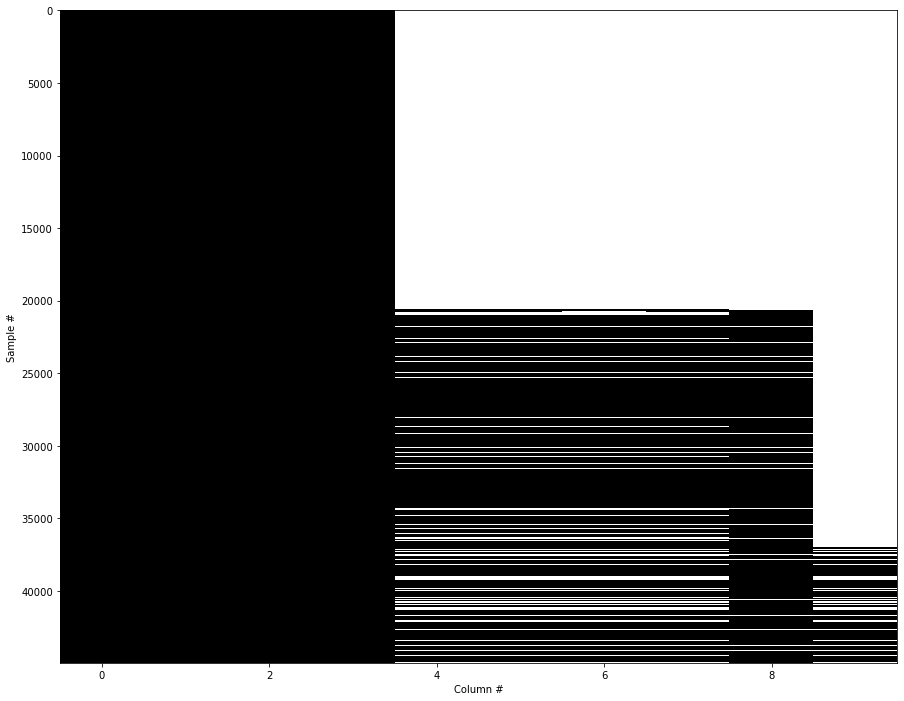

In [54]:
### plotting to see missing values:

fig, ax = plt.subplots(figsize=(15,12))
plt.imshow(full_long_data.isna(), aspect='auto',
           interpolation='nearest', cmap='gray')
ax.set_xlabel("Column #")
ax.set_ylabel("Sample #")

There are significant NAs prior to the date that vaccines are available, so we will limit our dataframe to the earliest date on the vaccination csv: 1/12/2021.

In [56]:
full_long_data_cleaned = full_long_data[full_long_data["date"] >= '2021-01-12']
full_long_data_cleaned

,state,date,cases,deaths,total_distributed,distributed_per_hundred,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,daily_vaccinations_per_million,total_boosters_per_hundred
355,Alabama,2021-01-12,3848,226,377025.0,7.69,0.15,1.59,NaN,NaN
1130,Alaska,2021-01-12,131,1,141600.0,19.36,0.74,4.90,NaN,NaN
1905,American Samoa,2021-01-12,0,0,10650.0,19.12,0.47,3.81,NaN,NaN
2680,Arizona,2021-01-12,8559,335,563025.0,7.74,0.11,1.94,NaN,NaN
3455,Arkansas,2021-01-12,3209,40,274400.0,9.09,0.00,1.35,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
41849,Virginia,2022-03-07,2388,105,18825505.0,220.55,72.17,186.70,855.0,33.14
42624,Washington,2022-03-07,2086,51,16957295.0,222.69,71.59,182.48,1063.0,36.02
43399,West Virginia,2022-03-07,1085,12,3871485.0,216.02,56.87,147.41,582.0,25.25
44174,Wisconsin,2022-03-07,1131,25,11118845.0,190.97,64.75,170.03,778.0,35.40


There are many states whose google search data was dropped due to missing values, so let's only keep the states that we have remaining:

In [57]:
keep_states = ['Alabama', 'Arizona', 'California', 'Colorado', 'Connecticut',
               'Florida', 'Georgia', 'Illinois', 'Indiana', 'Kentucky',
               'Louisiana', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
               'Missouri', 'Nevada', 'New Jersey', 'New York', 'North Carolina',
               'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'South Carolina',
               'Tennessee', 'Texas', 'Utah', 'Virginia', 'Washington',
               'Wisconsin']

In [59]:
full_long_data_cleaned = full_long_data_cleaned[full_long_data_cleaned['state'].isin(keep_states)]
full_long_data_cleaned['state'].unique().shape

(31,)

Plotting missing values once more...

Text(0, 0.5, 'Sample #')

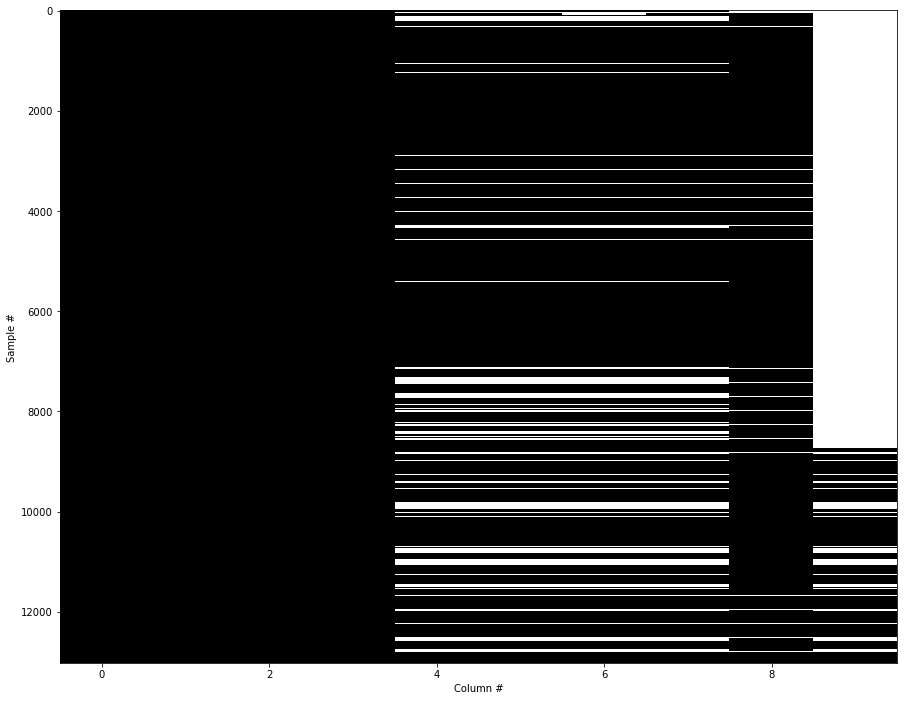

In [61]:
fig, ax = plt.subplots(figsize=(15,12))
plt.imshow(full_long_data_cleaned.isna(), aspect='auto',
           interpolation='nearest', cmap='gray')
ax.set_xlabel("Column #")
ax.set_ylabel("Sample #")

In [62]:
full_long_data_cleaned.head()

,state,date,cases,deaths,total_distributed,distributed_per_hundred,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,daily_vaccinations_per_million,total_boosters_per_hundred
355,Alabama,2021-01-12,3848,226,377025.0,7.69,0.15,1.59,NaN,NaN
2680,Arizona,2021-01-12,8559,335,563025.0,7.74,0.11,1.94,NaN,NaN
4230,California,2021-01-12,38940,587,3286050.0,8.32,0.25,2.07,NaN,NaN
5005,Colorado,2021-01-12,1511,29,516750.0,8.97,0.63,3.90,NaN,NaN
5780,Connecticut,2021-01-12,3689,33,250775.0,7.03,0.12,4.25,NaN,NaN


I don't really care for the "total boosters per hundred" feature; I think it's more important to have distributed-per-hundred which should stand in well for it.

In [67]:
full_long_data_cleaned.drop("total_boosters_per_hundred", axis=1, inplace=True)
full_long_data_cleaned.head()

/home/gani/anaconda3/envs/tf-n/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,state,date,cases,deaths,total_distributed,distributed_per_hundred,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,daily_vaccinations_per_million
355,Alabama,2021-01-12,3848,226,377025.0,7.69,0.15,1.59,NaN
2680,Arizona,2021-01-12,8559,335,563025.0,7.74,0.11,1.94,NaN
4230,California,2021-01-12,38940,587,3286050.0,8.32,0.25,2.07,NaN
5005,Colorado,2021-01-12,1511,29,516750.0,8.97,0.63,3.90,NaN
5780,Connecticut,2021-01-12,3689,33,250775.0,7.03,0.12,4.25,NaN


What states are missing most of their vaccination information?

In [70]:
full_long_data_cleaned[full_long_data_cleaned.transpose().notna().mean().sort_values() < 0.75]["state"].value_counts()

/tmp/ipykernel_319/675890378.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  full_long_data_cleaned[full_long_data_cleaned.transpose().notna().mean().sort_values() < 0.75]["state"].value_counts()


New York          420
Illinois          139
Kentucky           81
Pennsylvania       76
California         71
Washington         57
New Jersey         44
Georgia            39
Texas              36
Michigan           36
Maryland           33
Ohio               32
Utah               32
Massachusetts      31
Florida            31
Connecticut        30
Arizona            29
Louisiana          29
Missouri           29
Virginia           29
North Carolina     29
South Carolina     29
Alabama            28
Oregon             28
Colorado           28
Tennessee          28
Indiana            27
Oklahoma           27
Nevada             27
Minnesota          27
Wisconsin          27
Name: state, dtype: int64

As much as it pains me to see, New York and Illinois are missing the most datapoints by far. I will remove these from the list.

In [71]:
cleaned_df = full_long_data_cleaned[~full_long_data_cleaned['state'].isin(["Illinois", "New York"])]
cleaned_df.shape

(12180, 9)

Text(0, 0.5, 'Sample #')

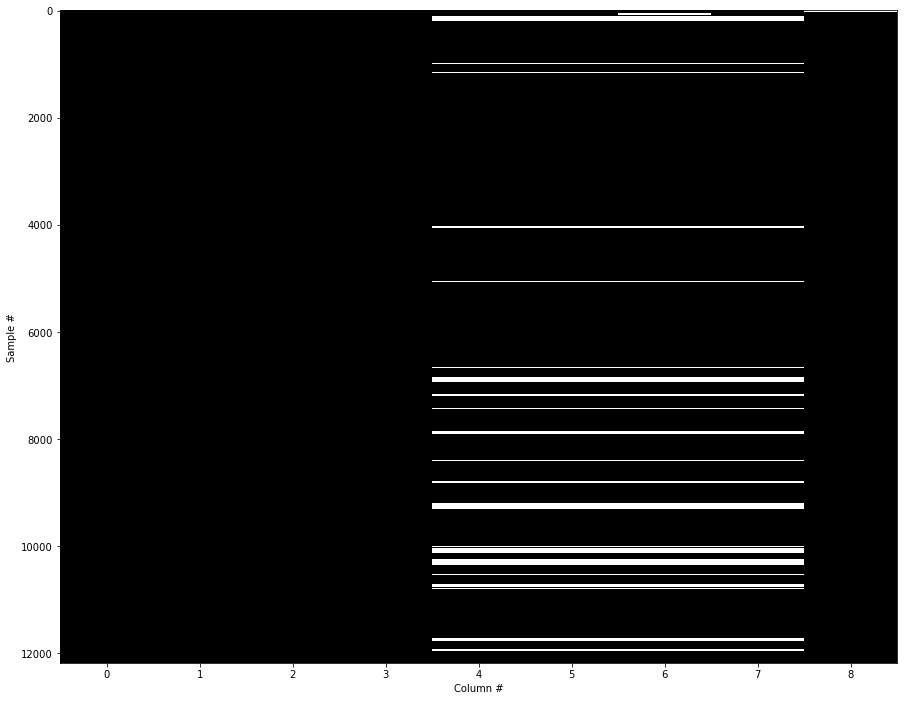

In [75]:
fig, ax = plt.subplots(figsize=(15,12))
plt.imshow(cleaned_df.isna(), aspect='auto',
           interpolation='nearest', cmap='gray')
ax.set_xlabel("Column #")
ax.set_ylabel("Sample #")

Now, are there any specific dates which are missing values?

In [77]:
cleaned_df[cleaned_df.transpose().notna().mean().sort_values() < 0.75]["date"].value_counts().head(30)

/tmp/ipykernel_319/3833026595.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cleaned_df[cleaned_df.transpose().notna().mean().sort_values() < 0.75]["date"].value_counts().head(30)


2021-11-28    29
2021-05-31    29
2021-12-26    29
2021-12-31    29
2022-01-01    29
2021-09-05    29
2021-01-16    29
2021-09-06    29
2022-01-02    29
2021-10-11    29
2022-01-16    29
2022-01-17    29
2021-07-05    29
2021-10-10    29
2022-01-03    29
2021-12-25    29
2021-11-11    29
2021-12-24    29
2021-01-17    29
2021-01-18    29
2021-11-27    29
2021-11-26    29
2021-02-15    29
2022-02-27    29
2022-02-20    29
2022-02-21    29
2021-11-25    29
2021-02-21     8
2021-09-22     4
2021-09-13     4
Name: date, dtype: int64

It does appear as if most missing values are related by date.

So there are 27 dates with missing values for all 29 remaining states. Since these are observations in a fixed-step time series model, I cannot drop these so I will linearly interpolate the rest of the values. This is probably not the best way to fill these points in, since I bet these datapoints are not missing at random (they are likely due to holidays or weekday/weekend reporting trends). The better way to do this is to train a model on the available data that incorporates these other covariates, and then impute using this model.

In [79]:
cleaned_df = cleaned_df.sort_values(['state','date'])

Just to show a date (2021-02-15) with a missing value...

In [112]:
cleaned_df[(cleaned_df['state'].isin(["Alabama"])) & (cleaned_df_imputed['date'] > '2021-02-13')]

,state,date,cases,deaths,total_distributed,distributed_per_hundred,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,daily_vaccinations_per_million
388,Alabama,2021-02-14,1075,0,965550.0,19.69,2.79,12.49,4368.0
389,Alabama,2021-02-15,674,2,NaN,NaN,NaN,NaN,4569.0
390,Alabama,2021-02-16,883,13,1015775.0,20.72,3.04,12.99,4245.0
391,Alabama,2021-02-17,679,89,1032175.0,21.05,3.15,13.26,3911.0
392,Alabama,2021-02-18,1198,78,1032175.0,21.05,3.37,13.71,3753.0
...,...,...,...,...,...,...,...,...,...
770,Alabama,2022-03-03,762,72,9271440.0,189.09,50.30,124.57,610.0
771,Alabama,2022-03-04,573,73,9290440.0,189.48,50.33,124.65,613.0
772,Alabama,2022-03-05,0,0,9297840.0,189.63,50.35,124.71,601.0
773,Alabama,2022-03-06,0,0,9297840.0,189.63,50.35,124.71,531.0


In [114]:
cleaned_df_imputed = cleaned_df.copy() # fills with previous value, limit of 2 days

In [125]:
def linear_imputation(df, col_list, how):
    for col in col_list:
        df[col] = df.groupby('state').apply(lambda x: x[[col]].interpolate(method='linear'))
    return df

In [126]:
cleaned_df_imputed = linear_imputation(cleaned_df_imputed, ["total_distributed", "distributed_per_hundred", "people_fully_vaccinated_per_hundred",
                                                            "total_vaccinations_per_hundred", "daily_vaccinations_per_million"], 'linear')
cleaned_df_imputed

,state,date,cases,deaths,total_distributed,distributed_per_hundred,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,daily_vaccinations_per_million
355,Alabama,2021-01-12,3848,226,377025.0,7.69,0.1500,1.590,NaN
356,Alabama,2021-01-13,3147,187,378975.0,7.73,0.1900,1.710,1205.0
357,Alabama,2021-01-14,3588,185,435350.0,8.88,0.2350,1.880,1445.0
358,Alabama,2021-01-15,2945,85,444650.0,9.07,0.2800,2.050,1525.0
359,Alabama,2021-01-16,3153,89,444650.0,9.07,0.2925,2.205,1529.0
...,...,...,...,...,...,...,...,...,...
44170,Wisconsin,2022-03-03,576,52,11106345.0,190.75,64.6600,169.700,846.0
44171,Wisconsin,2022-03-04,542,39,11114045.0,190.88,64.6900,169.810,999.0
44172,Wisconsin,2022-03-05,0,0,11118845.0,190.97,64.7100,169.900,824.0
44173,Wisconsin,2022-03-06,0,0,11118845.0,190.97,64.7400,169.990,835.0


In [118]:
cleaned_df_imputed[(cleaned_df_imputed['state'].isin(["Alabama"])) & (cleaned_df_imputed['date'] > '2021-02-13')]

,state,date,cases,deaths,total_distributed,distributed_per_hundred,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,daily_vaccinations_per_million
388,Alabama,2021-02-14,1075,0,965550.0,19.690,2.790,12.49,4368.0
389,Alabama,2021-02-15,674,2,990662.5,20.205,2.915,12.74,4569.0
390,Alabama,2021-02-16,883,13,1015775.0,20.720,3.040,12.99,4245.0
391,Alabama,2021-02-17,679,89,1032175.0,21.050,3.150,13.26,3911.0
392,Alabama,2021-02-18,1198,78,1032175.0,21.050,3.370,13.71,3753.0
...,...,...,...,...,...,...,...,...,...
770,Alabama,2022-03-03,762,72,9271440.0,189.090,50.300,124.57,610.0
771,Alabama,2022-03-04,573,73,9290440.0,189.480,50.330,124.65,613.0
772,Alabama,2022-03-05,0,0,9297840.0,189.630,50.350,124.71,601.0
773,Alabama,2022-03-06,0,0,9297840.0,189.630,50.350,124.71,531.0


Text(0, 0.5, 'Sample #')

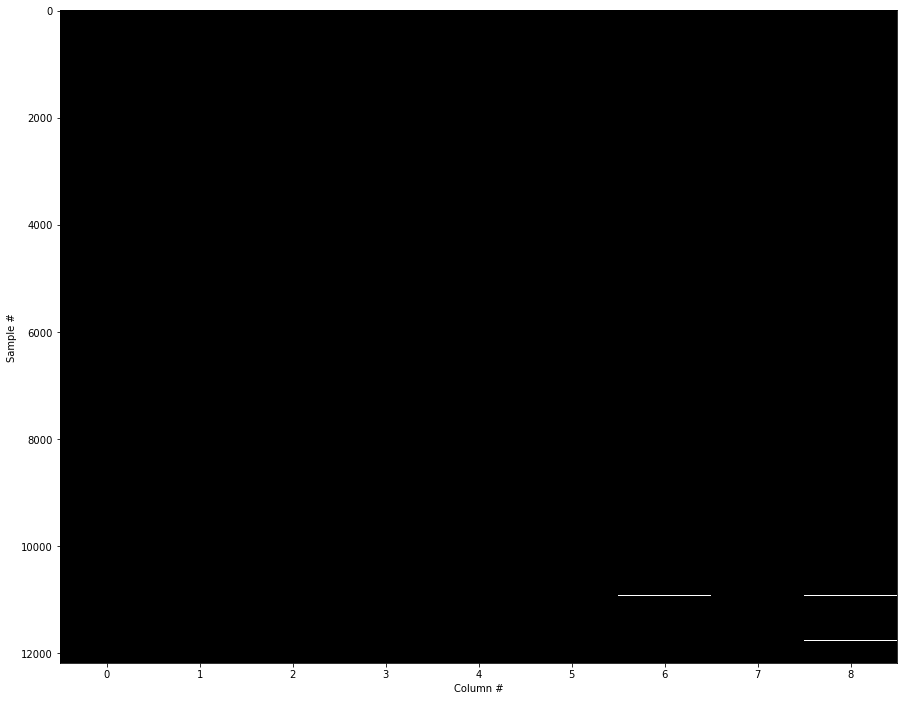

In [119]:
fig, ax = plt.subplots(figsize=(15,12))
plt.imshow(cleaned_df_imputed.isna(), aspect='auto',
           interpolation='nearest', cmap='gray')
ax.set_xlabel("Column #")
ax.set_ylabel("Sample #")

Interestingly, there are still a few missing values. Let's look at what they are.

In [124]:
cleaned_df_imputed[cleaned_df_imputed.isnull().any(axis=1)]

,state,date,cases,deaths,total_distributed,distributed_per_hundred,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,daily_vaccinations_per_million
355,Alabama,2021-01-12,3848,226,377025.0,7.69,0.15,1.59,NaN
2680,Arizona,2021-01-12,8559,335,563025.0,7.74,0.11,1.94,NaN
4230,California,2021-01-12,38940,587,3286050.0,8.32,0.25,2.07,NaN
5005,Colorado,2021-01-12,1511,29,516750.0,8.97,0.63,3.90,NaN
5780,Connecticut,2021-01-12,3689,33,250775.0,7.03,0.12,4.25,NaN
8880,Florida,2021-01-12,14896,156,1676300.0,7.80,0.19,2.95,NaN
9655,Georgia,2021-01-12,9193,187,960975.0,9.05,0.07,1.61,NaN
14305,Indiana,2021-01-12,3139,54,540475.0,8.03,0.35,2.85,NaN
16630,Kentucky,2021-01-12,3022,22,329450.0,7.37,0.14,2.96,NaN
17405,Louisiana,2021-01-12,4705,53,368300.0,7.92,0.39,3.07,NaN


All missing values are in the first dates, so we will again impute by backfilling.

In [132]:
cleaned_df_imputed = cleaned_df_imputed.bfill()
cleaned_df_imputed.head()

,state,date,cases,deaths,total_distributed,distributed_per_hundred,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,daily_vaccinations_per_million
355,Alabama,2021-01-12,3848,226,377025.0,7.69,0.1500,1.590,1205.0
356,Alabama,2021-01-13,3147,187,378975.0,7.73,0.1900,1.710,1205.0
357,Alabama,2021-01-14,3588,185,435350.0,8.88,0.2350,1.880,1445.0
358,Alabama,2021-01-15,2945,85,444650.0,9.07,0.2800,2.050,1525.0
359,Alabama,2021-01-16,3153,89,444650.0,9.07,0.2925,2.205,1529.0


In [133]:
cleaned_df_imputed.to_csv("cases_deaths_vaccinations_byState_imputed.csv", index=False, sep=',')

In [135]:
cleaned_df_imputed['state'].unique()

array(['Alabama', 'Arizona', 'California', 'Colorado', 'Connecticut',
       'Florida', 'Georgia', 'Indiana', 'Kentucky', 'Louisiana',
       'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Missouri',
       'Nevada', 'New Jersey', 'North Carolina', 'Ohio', 'Oklahoma',
       'Oregon', 'Pennsylvania', 'South Carolina', 'Tennessee', 'Texas',
       'Utah', 'Virginia', 'Washington', 'Wisconsin'], dtype=object)

### Next, let's do some basic longitudinal assessment using the given dataframe...

First, do the cases and deaths line up between different states?

In [10]:
cleaned_df_imputed = pd.read_csv("cases_deaths_vaccinations_byState_imputed.csv", parse_dates=["date"])

In [11]:
test_df = cleaned_df_imputed.copy()
test_df = test_df[test_df['state'].str.match('California|Massachusetts|Ohio|Texas')]
test_df

,state,date,cases,deaths,total_distributed,distributed_per_hundred,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,daily_vaccinations_per_million
840,California,2021-01-12,38940,587,3286050.0,8.32,0.250,2.070,1903.0
841,California,2021-01-13,37283,532,3435650.0,8.70,0.340,2.260,1903.0
842,California,2021-01-14,42860,449,3540175.0,8.96,0.430,2.470,2012.0
843,California,2021-01-15,41507,589,3548575.0,8.98,0.520,2.720,2165.0
844,California,2021-01-16,41376,544,3548575.0,8.98,0.555,2.965,2237.0
...,...,...,...,...,...,...,...,...,...
10495,Texas,2022-03-03,4245,118,58996495.0,203.47,60.160,153.470,1214.0
10496,Texas,2022-03-04,4058,232,59080695.0,203.76,60.190,153.590,1210.0
10497,Texas,2022-03-05,4018,101,59131295.0,203.93,60.220,153.700,1038.0
10498,Texas,2022-03-06,558,46,59133195.0,203.94,60.220,153.700,927.0


In [12]:
import mpl_axes_aligner as ax_align
import matplotlib.dates as mdates

In [15]:
### making some helper functions to graph a few things...

def grapher_byState(ax, df, states, series, names, dates=[]):
    if len(dates) > 0:
        date_cond = (df['date'] > dates[0]) & (df['date'] < dates[1])
    else:
        date_cond = (df['date'] > '2019-01-01')
    
    ax_second = ax.twinx()
    
    new_df = df[date_cond]
    new_df = new_df[new_df['state'].str.match(states)]
    
    ax.plot(new_df['date'], new_df[series[0]], label=names[0], alpha=0.7)
    ax_second.plot(new_df['date'], new_df[series[1]], label=names[1], color='orange', alpha = 0.7)
    ax.set_title(states + f" {names[0]} and {names[1]}")
    ax.set_ylabel(names[0])
    ax_second.set_ylabel(names[1])
    ax_align.align.yaxes(ax, 0, ax_second, 0)
    
    ax.legend()
    ax_second.legend()
    

def grapher(ax, df, states, dates, series, names):
    date_cond = (df['date'] > dates[0]) & (df['date'] < dates[1])
    
    for i, state in enumerate(states):
        state_cond = df['state'].str.match(state)
        ax.plot(df[state_cond & date_cond]["date"], df[state_cond & date_cond][series],
                label=state, alpha=0.7)
    ax.set_title(", ".join(states) + " Cases")
    ax.set_xlabel('Date')
    ax.set_ylabel('Cases')
    ax.legend()

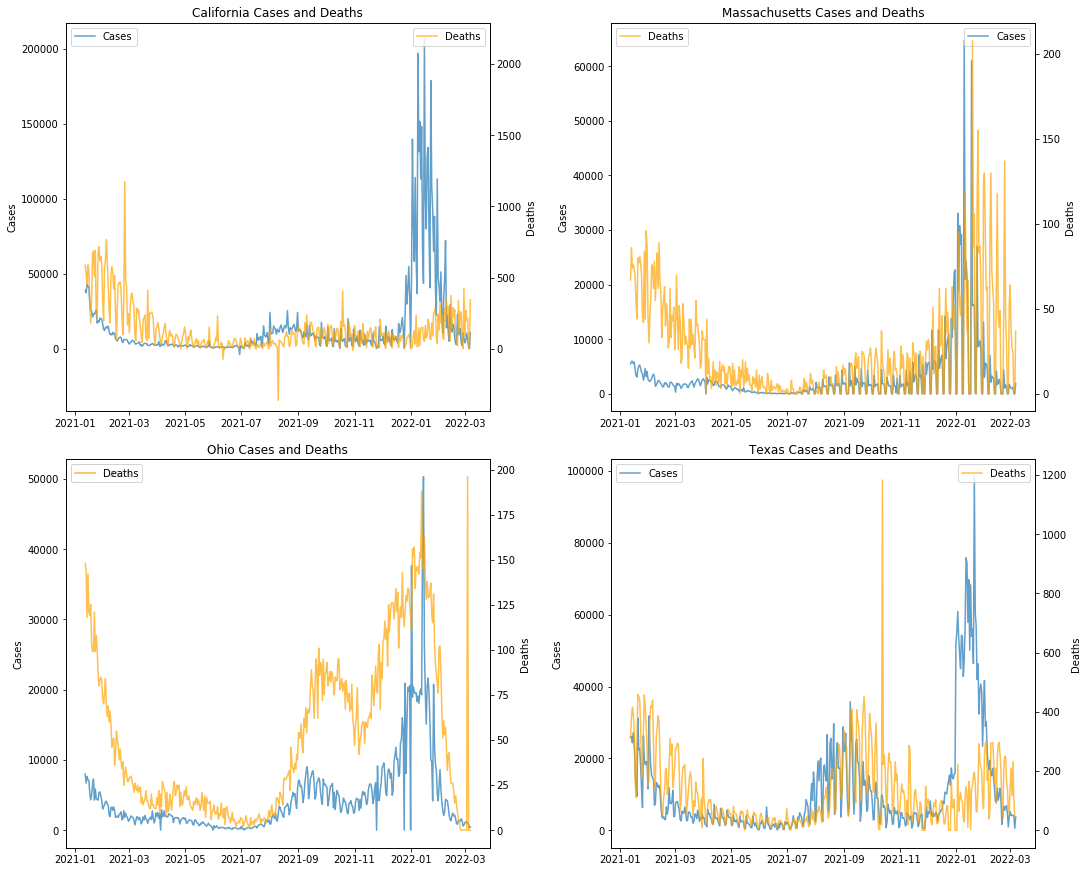

In [16]:
states = ["California", "Massachusetts", "Ohio", "Texas"]

fig, axs = plt.subplots(2, 2, figsize = (15,12), constrained_layout=True)

for i, ax in enumerate(axs.reshape(-1)):
    grapher_byState(ax, test_df, states[i], ["cases", "deaths"], ["Cases", "Deaths"])

Now, it seems as if the cases and deaths move similarly, but there is clearly a hump in deaths reported between 2021-09 and 2022-01 in Ohio that doesn't correspond to cases. Additionally, Massachusetts has something strange going on in its death reports, with lots of zeros (likely on days where the state database is not updated). For all of these states, I should look into sliding-window smoothing to remove some of the nonsense variability here.

I am not sure what "negative deaths" or "negative cases" means. I will need to look back at the original data report to see if they provide an explanation.

Next, let's visualize cases during the 2021 holiday period.

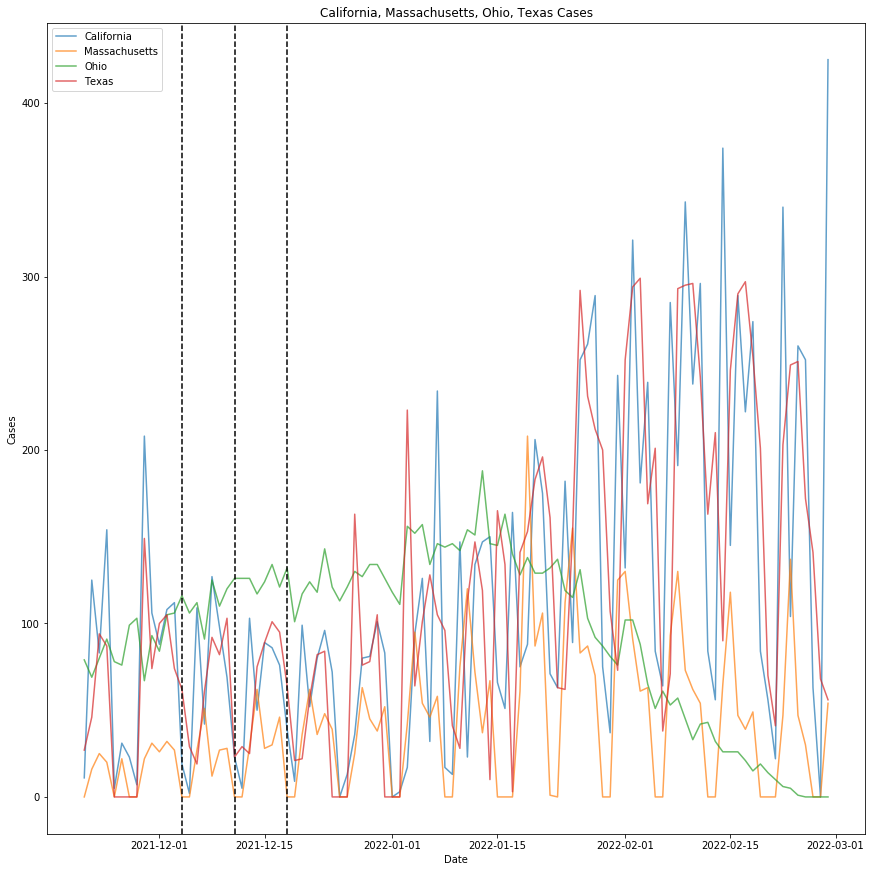

In [23]:
states = ["California", "Massachusetts", "Ohio", "Texas"]

fig, ax = plt.subplots(1,1, figsize=(12,12), constrained_layout=True)

grapher(ax, test_df, states = states, dates=['2021-11-20','2022-03-01'],
        series='deaths', names = 'deaths')

### It appears as if the reporting issues are weekly. I drew three black lines here to visualize weekly cycles.
ax.axvline(x=pd.to_datetime("2021-12-04"), c="black", linestyle='--')
ax.axvline(x=pd.to_datetime("2021-12-11"), c="black", linestyle='--')
ax.axvline(x=pd.to_datetime("2021-12-18"), c="black", linestyle='--')

You can see the cyclic pattern in Massachusetts and Texas deaths now: it seems like there are a few days each week where cases are not reported (perhaps the weekend)? I will need to add another feature (day of the week) in order to let the model easily pick this issue up.

In [151]:
test_df.head()

,state,date,cases,deaths,total_distributed,distributed_per_hundred,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,daily_vaccinations_per_million
4230,California,2021-01-12,38940,587,3286050.0,8.32,0.250,2.070,1903.0
4231,California,2021-01-13,37283,532,3435650.0,8.70,0.340,2.260,1903.0
4232,California,2021-01-14,42860,449,3540175.0,8.96,0.430,2.470,2012.0
4233,California,2021-01-15,41507,589,3548575.0,8.98,0.520,2.720,2165.0
4234,California,2021-01-16,41376,544,3548575.0,8.98,0.555,2.965,2237.0


Next, does population date of vaccination seem to have any relationship with death rate?

This will be hard to assess by eye, especially since vaccination and death rate would presumably be negatively correlated, and the effect of vaccination would not show up in a depressed death rate until months later. I will need to think of an alternate way of assessing this question.

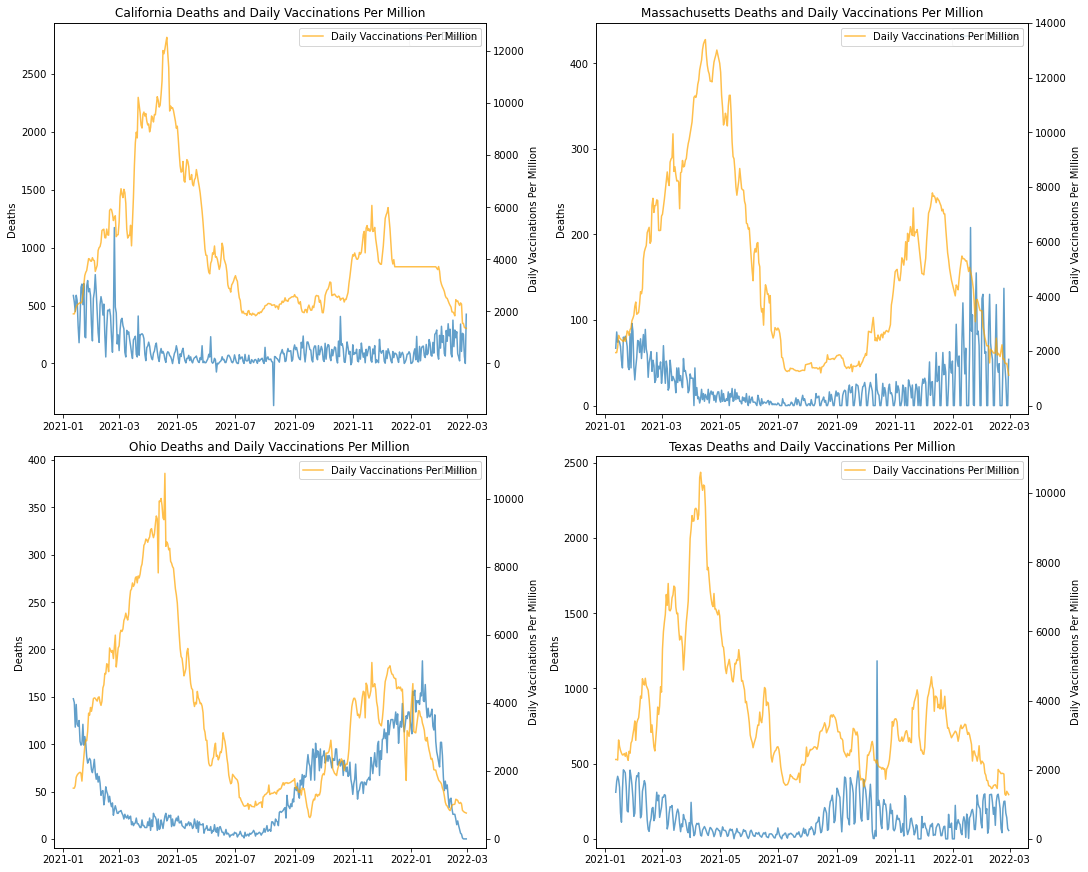

In [154]:
states = ["California", "Massachusetts", "Ohio", "Texas"]

fig, axs = plt.subplots(2, 2, figsize = (15,12), constrained_layout=True)

for i, ax in enumerate(axs.reshape(-1)):
    grapher_byState(ax, test_df, states[i], ["deaths", "daily_vaccinations_per_million"], ["Deaths", "Daily Vaccinations Per Million"], dates=['2020-03-01', '2022-03-01'])


Since we noticed weekly trends here, I'm going to add another variable to represent the day of the week.

In [24]:
cleaned_df_imputed

,state,date,cases,deaths,total_distributed,distributed_per_hundred,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,daily_vaccinations_per_million
0,Alabama,2021-01-12,3848,226,377025.0,7.69,0.1500,1.590,1205.0
1,Alabama,2021-01-13,3147,187,378975.0,7.73,0.1900,1.710,1205.0
2,Alabama,2021-01-14,3588,185,435350.0,8.88,0.2350,1.880,1445.0
3,Alabama,2021-01-15,2945,85,444650.0,9.07,0.2800,2.050,1525.0
4,Alabama,2021-01-16,3153,89,444650.0,9.07,0.2925,2.205,1529.0
...,...,...,...,...,...,...,...,...,...
12175,Wisconsin,2022-03-03,576,52,11106345.0,190.75,64.6600,169.700,846.0
12176,Wisconsin,2022-03-04,542,39,11114045.0,190.88,64.6900,169.810,999.0
12177,Wisconsin,2022-03-05,0,0,11118845.0,190.97,64.7100,169.900,824.0
12178,Wisconsin,2022-03-06,0,0,11118845.0,190.97,64.7400,169.990,835.0


In [27]:
cleaned_df_imputed["day_of_week"] = cleaned_df_imputed["date"].dt.day_name()
cleaned_df_imputed[(cleaned_df_imputed["date"] >= "2021-12-01") & (cleaned_df_imputed["state"] == "Massachusetts")]

# Indeed, Massachusetts doesn't report cases and deaths on weekends.

,state,date,cases,deaths,total_distributed,distributed_per_hundred,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,daily_vaccinations_per_million,day_of_week
4943,Massachusetts,2021-12-01,5303,26,13418760.0,194.69,71.28,168.96,4784.0,Wednesday
4944,Massachusetts,2021-12-02,5679,32,13475520.0,195.51,71.44,169.70,5115.0,Thursday
4945,Massachusetts,2021-12-03,5765,27,13541520.0,196.47,71.60,170.38,5387.0,Friday
4946,Massachusetts,2021-12-04,0,0,13552150.0,196.62,71.77,171.34,6043.0,Saturday
4947,Massachusetts,2021-12-05,0,0,13537870.0,196.41,71.94,172.19,6544.0,Sunday
...,...,...,...,...,...,...,...,...,...,...
5035,Massachusetts,2022-03-03,974,27,16214790.0,235.25,77.71,207.43,1166.0,Thursday
5036,Massachusetts,2022-03-04,1182,25,16236890.0,235.57,77.73,207.54,1107.0,Friday
5037,Massachusetts,2022-03-05,0,0,16250090.0,235.76,77.76,207.65,1027.0,Saturday
5038,Massachusetts,2022-03-06,0,0,16250690.0,235.77,77.76,207.65,1028.0,Sunday


In [29]:
cleaned_df_imputed.state.unique()

array(['Alabama', 'Arizona', 'California', 'Colorado', 'Connecticut',
       'Florida', 'Georgia', 'Indiana', 'Kentucky', 'Louisiana',
       'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Missouri',
       'Nevada', 'New Jersey', 'North Carolina', 'Ohio', 'Oklahoma',
       'Oregon', 'Pennsylvania', 'South Carolina', 'Tennessee', 'Texas',
       'Utah', 'Virginia', 'Washington', 'Wisconsin'], dtype=object)

In [28]:
cleaned_df_imputed = pd.read_csv("cases_deaths_vaccinations_byState_imputed.csv", parse_dates=["date"])

*Do you feel the dataset will enable you to further progress with your project goals?*

I think so -- the data appears rich enough but it's now clear to me that the time series needs to be smoothed. I still haven't integrated the metadata into the longitudinal data so I am curious to see whether there are any features that moderate the relationship between cases and deaths, spread/peak of case loads, etc.